# Basic Setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import os
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
from natsort import natsorted, ns
import glob
from pymer4.models import Lmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
%load_ext rpy2.ipython

fpath = 'where/you/have/the/data'

In [3]:
%%R
library('lme4')
library('lmerTest')
library('lsmeans')

# Patient - Interaction - Overall pain rating

In [8]:
pat_data = pd.read_csv(os.path.join(fpath,'study3_pat_interaction_rating_data.csv'))
pat_mean = pat_data.groupby(['DyadID','Condition_sequence',
                             'Block','Half'])['Pain_Rating'].mean().reset_index()

In [9]:
pat_data['trials_c'] = pat_data.N - pat_data.N.mean()

In [10]:
%%R -i pat_data
pat_data$Site <- factor(pat_data$Site)
pat_data$Condition <- factor(pat_data$Condition_new)
pat_data$Color <- factor(pat_data$Current_Color)
pat_overall_m <- lmer(Pain_Rating ~ Site + trials_c + Color + Condition
                  + (1 + trials_c + Condition | DyadID), data = pat_data)
summary(pat_overall_m)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: Pain_Rating ~ Site + trials_c + Color + Condition + (1 + trials_c +  
    Condition | DyadID)
   Data: pat_data

REML criterion at convergence: 8181.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3426 -0.5749 -0.0570  0.5834  3.4194 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 DyadID   (Intercept) 289.523  17.015              
          trials_c      2.141   1.463    0.64      
          Condition1   34.987   5.915   -0.37 -0.35
 Residual             259.097  16.096              
Number of obs: 960, groups:  DyadID, 30

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  33.7102     3.4373  37.7000   9.807 6.43e-12 ***
Site2        -2.4126     1.4741 878.4000  -1.637   0.1021    
Site3        -0.7550     1.4769 883.4000  -0.511   0.6093    
Site4        -2.7310     1.4738 878.0000  -1.853   

## Figure 4(B-3)

[Text(0, 0, 'Control'),
 Text(1, 0, 'Thermedol'),
 Text(2, 0, 'Thermedol'),
 Text(3, 0, 'Control')]

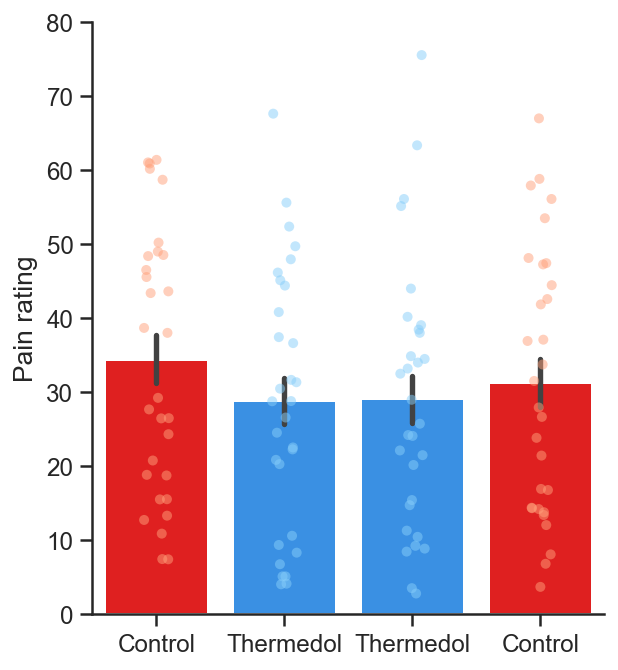

In [11]:
sns.set(style="ticks", font_scale=1.1)
g = sns.catplot(x="Condition_sequence", y="Pain_Rating", 
    palette={'Thermedol1':'dodgerblue','Thermedol2':'dodgerblue','Vaseline1':'red','Vaseline2':'red'}
    ,units='DyadID',n_boot=5000, ci=68, data=pat_mean, kind="bar"
    , order=['Vaseline1','Thermedol1','Thermedol2','Vaseline2'], aspect=0.9)

g = sns.stripplot(x="Condition_sequence", y="Pain_Rating", 
    palette={'Thermedol1':'lightskyblue','Thermedol2':'lightskyblue','Vaseline1':'lightsalmon',
            'Vaseline2':'lightsalmon'},
    data=pat_mean, order=['Vaseline1','Thermedol1','Thermedol2','Vaseline2'],alpha=.5)

g.set(ylim=(0, 80))
plt.ylabel('Pain rating')
plt.xlabel('')
g.set_xticklabels(["Control","Thermedol","Thermedol","Control"])

# Patient - Interaction - Beliefs of Effectiveness and doctors' perceived empathy

In [12]:
pat_q = pd.read_csv(os.path.join(fpath,'study3_pat_interaction_belief_data.csv'))

In [14]:
%%R -i pat_q
pat_q$Time <- factor(pat_q$Time)
pat_q$Condition <- factor(pat_q$Condition)
effectivness_model <- lmer(effectiveness ~ Time*Condition + (1 + Condition | DyadID), data = pat_q)
anova(effectivness_model)

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF DenDF F.value   Pr(>F)   
Time           3244.5  3244.5     1   178 10.1427 0.001711 **
Condition      3339.2  3339.2     1    29 10.4386 0.003066 **
Time:Condition 1591.5  1591.5     1   178  4.9751 0.026964 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R -i pat_q
pat_q$Time <- factor(pat_q$Time)
pat_q$Condition <- factor(pat_q$Condition)
empathy_model <- lmer(doc_empathy ~ Time*Condition + (1 + Condition | DyadID), data = pat_q)
summary(empathy_model)

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: doc_empathy ~ Time * Condition + (1 + Condition | DyadID)
   Data: pat_q

REML criterion at convergence: 2063.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.8181 -0.3180  0.0287  0.4743  2.7040 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 DyadID   (Intercept) 415.534  20.385       
          Condition1    6.608   2.571   0.32
 Residual             243.488  15.604       
Number of obs: 240, groups:  DyadID, 30

Fixed effects:
                 Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)        51.173      4.232  36.790  12.092 2.22e-14 ***
Time2               6.366      2.849 178.000   2.234   0.0267 *  
Condition1          6.875      2.887  96.030   2.381   0.0192 *  
Time2:Condition1   -5.914      4.029 178.000  -1.468   0.1439    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed

## Figure 4(B-2)

In [21]:
pat_q_diff = pd.read_csv(os.path.join(fpath,'study3_pat_interaction_belief_diff_data.csv'))

[Text(0, 0, 'Control'),
 Text(1, 0, 'Thermedol'),
 Text(2, 0, 'Thermedol'),
 Text(3, 0, 'Control')]

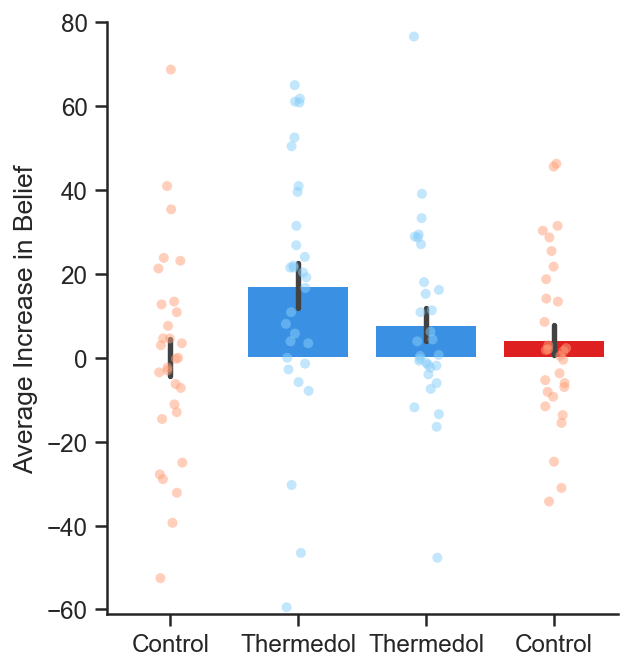

In [22]:
sns.set(style="ticks", font_scale=1.1)
g = sns.catplot(x="Condition_with_sequence", y="effective_diff", 
    palette={'Thermedol1':'dodgerblue','Thermedol2':'dodgerblue','Vaseline1':'red','Vaseline2':'red'}
                   ,units='DyadID',n_boot=5000, ci=68, data=pat_q_diff, kind="bar", aspect=0.9)

g = sns.stripplot(x="Condition_with_sequence", y="effective_diff", 
    palette={'Thermedol1':'lightskyblue','Thermedol2':'lightskyblue','Vaseline1':'lightsalmon','Vaseline2':'lightsalmon'},
    data=pat_q_diff, order=['Vaseline1','Thermedol1','Thermedol2','Vaseline2'],alpha=.5)

g.set(ylim=(-61, 80))
plt.ylabel('Average Increase in Belief')
plt.xlabel('')
g.set_xticklabels(["Control","Thermedol","Thermedol","Control"])